# Pulsar stars classification

Dataframe source : https://archive.ics.uci.edu/ml/datasets/HTRU2. We change the column names in order to have shorter names.

We assume that the work of visualisation of the variable and their interaction is done. We only present here how to build a random forest using Julia, and also how to plot a 3D partial dependance plot.

In [1]:
using DataFrames, CSV, StatsBase, Random, MLDataUtils

df = CSV.read("pulsar_stars.csv")
first(df, 6)

,Mean_ip,Std_ip,Excess_kurtosis_ip,Skewness_ip,Mean_DM,Std_DM,Excess_kurtosis_DM
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,140.562,55.6838,-0.234571,-0.699648,3.19983,19.1104,7.97553
2,102.508,58.8824,0.465318,-0.515088,1.67726,14.8601,10.5765
3,103.016,39.3416,0.323328,1.05116,3.12124,21.7447,7.73582
4,136.75,57.1784,-0.0684146,-0.636238,3.64298,20.9593,6.8965
5,88.7266,40.6722,0.600866,1.12349,1.17893,11.4687,14.2696
6,93.5703,46.6981,0.531905,0.416721,1.63629,14.5451,10.6217


Two columns have been omitted, let's at least see their names :

In [2]:
names(df)

9-element Array{Symbol,1}:
 :Mean_ip
 :Std_ip
 :Excess_kurtosis_ip
 :Skewness_ip
 :Mean_DM
 :Std_DM
 :Excess_kurtosis_DM
 :Skewness_DM
 :target

We need to create a train and test dataset. Using the function avaible on this repo, we have :

In [3]:
include("stratified_train_test_split.jl")

y_column_number = 9 ; target = 1
X_train, X_test, y_train, y_test = stratified_train_test_split(df, y_column_number, target)

mean(vector) = sum(vector) / length(vector)

using Printf
@printf("Train proportion of target : %0.4f, and test proportion : %0.4f", mean(y_train), mean(y_test))

Train proportion of target : 0.0916, and test proportion : 0.0916

Let's build a random forest. We need to use the *DecisionTree* package.

In [4]:
using DecisionTree

n_subfeatures=-1 ; n_trees = 100
model = build_forest(y_train, X_train, n_subfeatures, n_trees)

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 199.25
Avg Depth:  21.14

We need to know whether this random forest perfom well or not. Let's look at the confusion matrix :

In [5]:
y_pred = apply_forest(model, X_test)
confusion_matrix(y_test, y_pred)

2×2 Array{Int64,2}:
 4044   21
   53  357

Classes:  [0, 1]
Matrix:   
Accuracy: 0.983463687150838
Kappa:    0.8970413575679188

We should not look at the Accuracy since the dataset is imbalanced, but looking at the confusion matrix it seems that the random forest does a decent job.

We now would like to view a partial dependance plot in 3D let's code this in Julia :

100
200
300
400
500
600
700
800
900


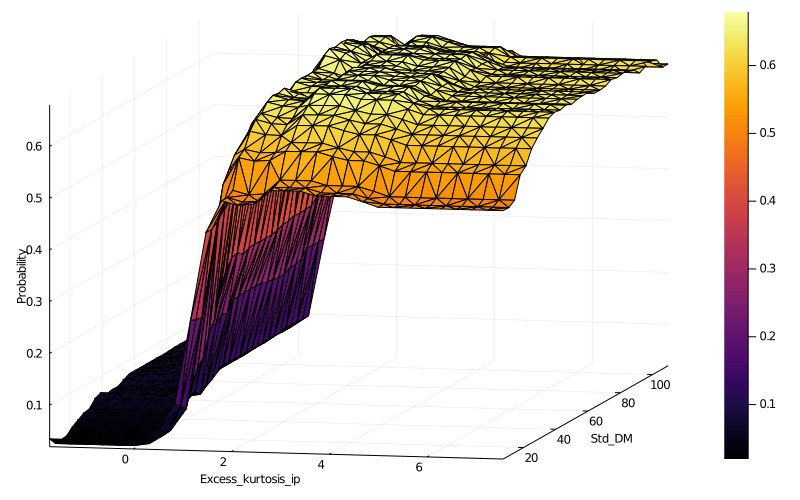

In [6]:
function change_value(df, column_number, value)
    X = copy(df)
    X[:, column_number] = value * ones(size(X)[1])
    return X
end



function create_X_Y_Z(df, column_1, column_2, n, verbose=true)
    abscisse_1 = LinRange(minimum(df[:, column_1]), maximum(df[:, column_1]), n)
    abscisse_2 = LinRange(minimum(df[:, column_2]), maximum(df[:, column_2]), n)
    
    X = []
    Y = []
    Z = []
    
    count = 0
    
    for a1 in abscisse_1
        X_1 = change_value(df, column_1, a1)
        for a2 in abscisse_2
            X_2 = change_value(X_1, column_2, a2)
            
            y_pred_proba = apply_forest_proba(model, X_2, [0, 1])[:, 2]
            
            append!(X, a1)
            append!(Y, a2)
            append!(Z, mean(y_pred_proba))
            
            count += 1
            if (count % 100 == 0) & (verbose)
                println(count)
            end
        end
    end
    
    X = convert(Array{Float64, 1}, X)
    Y = convert(Array{Float64, 1}, Y)
    Z = convert(Array{Float64, 1}, Z)
    
    return X, Y, Z
end

column_1 = 3
column_2 = 6
n = 30

X, Y, Z = create_X_Y_Z(X_test, column_1, column_2, n)

using Plots

plot(X, Y, Z, st=:surface, 
    xlabel="Excess_kurtosis_ip", 
    ylabel="Std_DM",
    zlabel="Probability",
    xguidefontsize=8,
    yguidefontsize=8,
    zguidefontsize=8,
    size = (800, 500),
    camera=(20, 30)
)

We see that *Excess_kurtosis_ip* seems to have a lot of weight on the final decision, but *Std_DM* doesn't.
With the 3D-Partial dependance plot we can see two classic partial dependance plot and as a bonus the interaction between the two variable we're looking at.

We choosed to have 30 points per variable (so we compute 900 times the y_pred vector). Which takes time.
Since Julia is designed to have speed performance close to C, we can I a few seconds have that graph.

It is not as rigorous as a benchmark, but I tried the same code in Python and Julia, on another dataset (30 000+ observations). With 30 points per variable, Python plot the graph is 88s while Julie does it in 35s.